In [ ]:
import pandas

Connecting google drive with colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


giving the path to dataset

In [ ]:
import os
#Defining the path to dataset in the drive
base_dir='/content/drive/MyDrive/zip datafiles/dataverse_files'

train_images_part1 = os.path.join(base_dir, 'HAM10000_images_part_1.zip')
train_images_part2 = os.path.join(base_dir, 'HAM10000_images_part_2.zip')
metadata_path = os.path.join(base_dir, 'HAM10000_metadata')

unzipping the files

In [ ]:
import zipfile

# Unzipping part 1
with zipfile.ZipFile(train_images_part1, 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/part1')

# Unzipping part 2
with zipfile.ZipFile(train_images_part2, 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/part2')

reading the data and displaying first few rows

In [ ]:
import pandas as pd

metadata_file = os.path.join(base_dir, 'HAM10000_metadata')
metadata = pd.read_csv(metadata_file)
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,vidir_modern


defining lable path and image path

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#Image paths and labels from metadata
image_paths = metadata['image_id'].apply(lambda x: '/content/HAM10000/part1/' + x + '.jpg' if os.path.exists('/content/HAM10000/part1/' + x + '.jpg')
                                          else '/content/HAM10000/part2/' + x + '.jpg')

In [ ]:
labels = metadata['dx']

# Encoding labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

Preprocessing images  to a uniform size

In [ ]:
# Preprocessing images
IMG_SIZE = 128  # Resizing the images to 128x128

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype('float32') / 255.0  # Normalizing pixel values between 0 and 1
    return image

# Applying preprocessing to all images
images = np.array([preprocess_image(img_path) for img_path in image_paths])

spliting the data into training & testing part

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

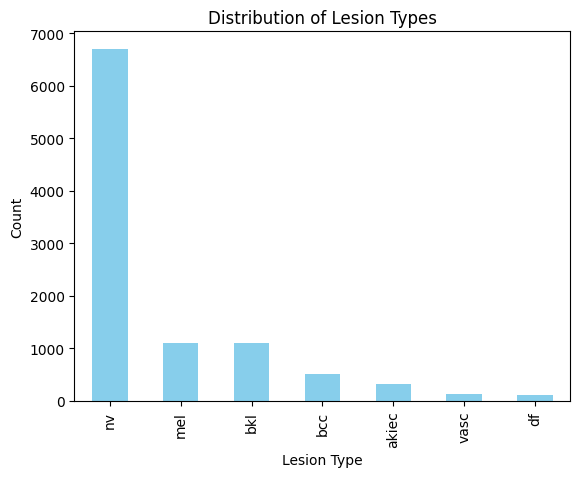

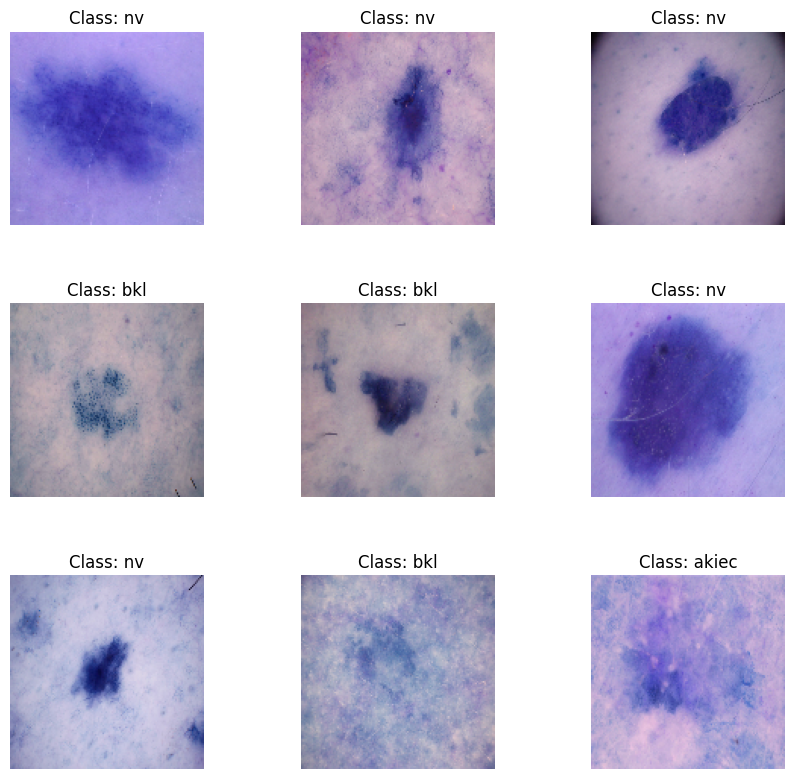

In [ ]:
import matplotlib.pyplot as plt

# Plotting distribution of classes
metadata['dx'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Lesion Types')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

# Displaying some sample images with labels
def plot_sample_images(X, y, label_encoder):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in np.arange(0, 9):
        axes[i].imshow(X[i])
        label = label_encoder.inverse_transform([np.argmax(y[i])])[0]
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()

plot_sample_images(X_train, y_train, label_encoder)

In [ ]:
import